#### Cycling through data science: tool <img src="../images/bicycle32.png" style="float:right">

Preamble: Gather features which might help predict the number of bike users in any given day in Washington, DC, and evaluate the significance of those features and the robustness of the predictions. This is essentially a `regression problem`. Regression problems are inference problems in that we infer, or predict, parameters of a population from a sample. They are also specifically `supervised learning` problems that entail building a model to make predictions about a continuous target variable.

##### Select input here to make a prediction of the number of bike users.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, impute, model_selection, preprocessing, compose, pipeline, metrics, linear_model, neighbors
import catboost

from ipywidgets import widgets, Output, Layout, Label, HBox, GridspecLayout
from IPython.display import display, clear_output, HTML

import joblib
from loguru import logger
import warnings

In [2]:
# Set parameters
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
def plot_correlation_features_to_target(data, target):
    '''Plot heatmap of how features correlate to the target variable.'''
    df_corr = data.corr()[[target]].sort_values(by=target, ascending=False)
    plt.title(label=f'Correlation of features to {target}')
    sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap='coolwarm', xticklabels=False)

In [4]:
def on_predict_submit(incoming):
    '''Display processed incoming html inputs.'''
    with output:
        clear_output()
        X_input = []
        features = ['temp', 'temp_feel', 'humdity', 'windspeed', 'season', 'month', 'is_holiday', 'weekday', 'is_workingday', 'weather']
        X_input = pd.DataFrame(columns=features)
        map_list = ['season', 'month', 'weekday', 'is_holiday','is_workingday', 'weather']
        X_input = map_to_numeric(data=X_input, columns=map_list)
        input_variables = [input_temp.value/100, input_temp_feel.value/100, input_humidity.value, input_windspeed.value, input_season.value, input_month.value, input_is_holiday.value, input_weekday.value, input_is_workingday.value, input_weather.value]
        X_input.loc[1] = [x for x in input_variables]
        display_output = f"The number of predicted bikers in Washington DC is {model.predict(X=prepipe.transform(X=X_input))[0]:,.0f}"
        display(display_output)

In [5]:
# Map values to numeric
def map_to_numeric(data, columns):
    for column in columns:
        map_dict = get_map_dict(column)
        data[column] = data[column].map(map_dict)
    return data
    
def get_map_dict(feature):
    map_feature = {
    'season': {
        'Spring': 0,
        'Summer': 1,
        'Fall': 2,
        'Winter': 3
        }, 
    'month': {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr': 4,
        'May': 5,
        'Jun': 6,
        'Jul': 7,
        'Aug': 8,
        'Sep': 9,
        'Oct': 10,
        'Nov': 11,
        'Dec': 12
        }, 
    'weekday': {
        'Sun': 0,
        'Mon': 1,
        'Tue': 2,
        'Wed': 3,
        'Thu': 4,
        'Fri': 5,
        'Sat': 6
        },
    'is_workingday': {
        'Yes': 1,
        'No': 0
        },
    'is_holiday': {
        'Yes': 1,
        'No': 0
        },
    'weather': {
        'Clear': 0,
        'Mist': 1,
        'Light Snow': 2,
        'Heavy Rain': 3
        }
    }
    return map_feature[feature]

In [6]:
# Input month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
input_month = widgets.ToggleButtons(
    options=months,
    description='Month',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=months
)

# Input season
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
input_season = widgets.ToggleButtons(
    options=seasons,
    description='Season',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=months
)

# Input weekday
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
input_weekday = widgets.ToggleButtons(
    options=weekdays,
    description='Day',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=weekdays
)

# Input is_workingday
is_workingdays = ['Yes', 'No']
input_is_workingday = widgets.ToggleButtons(
    options=is_workingdays,
    description='Work day?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=is_workingdays
)

# Input is_holiday
is_holidays = ['Yes', 'No']
input_is_holiday = widgets.ToggleButtons(
    options=is_holidays,
    description='Holiday?',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=is_holidays
)

# Input weather
weathers = ['Clear', 'Mist', 'Light snow', 'Heavy rain']
input_weather = widgets.ToggleButtons(
    options=weathers,
    description='Weather',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=weathers
)

# Input temp
input_temp = widgets.FloatSlider(
    value=55.0,
    min=0,
    max=100.0,
    step=0.1,
    description='Temperature',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Input temp_feel
input_temp_feel = widgets.FloatSlider(
    value=55.0,
    min=0,
    max=100.0,
    step=0.1,
    description='Feels like',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Input humidity
input_humidity = widgets.FloatSlider(
    value=0.50,
    min=0,
    max=1.00,
    step=0.01,
    description='Humidity',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Input windspeed
input_windspeed = widgets.FloatSlider(
    value=0.20,
    min=0,
    max=0.70,
    step=0.01,
    description='Windspeed',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

# Input Predict
input_predict = widgets.Button(
    value=False,
    description='Predict',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict',
    icon='check'
)

In [7]:
# Button for Predict
button_predict = widgets.Button(
    value=False,
    description='Predict',
    disabled=False,
    button_style='primary',
    tooltip='Predict',
    icon='',
)
# Output/results
output = Output()
button_predict.on_click(on_predict_submit)

In [8]:
# Create a x*y grid layout
grid = GridspecLayout(11, 5, height='600px', width='auto')
# Fill it in with widgets
grid[0:1, 0:] = input_season
grid[1:2, 0:] = input_month
grid[2:3, 0:] = input_weekday
grid[3:4, 0:] = input_is_workingday
grid[4:5, 0:] = input_is_holiday
grid[5:6, 0:] = input_weather
grid[6:7, 0:] = input_temp
grid[7:8, 0:] = input_temp_feel
grid[8:9, 0:] = input_humidity
grid[9:10, 0:] = input_windspeed
grid[10:11, 0:1] = button_predict
grid[10:11, 1:] = output
display(grid)

GridspecLayout(children=(ToggleButtons(description='Season', layout=Layout(grid_area='widget001'), options=('S…

[AccuWeather - Washington DC](https://www.accuweather.com/en/us/washington-dc/20006/daily-weather-forecast/327659?day=1)

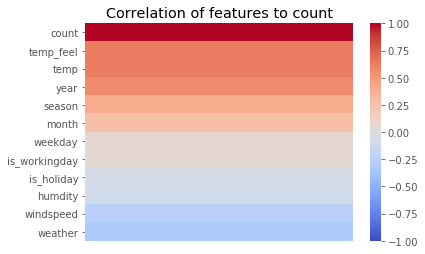

In [9]:
# Load daily bike count dataset
path = '../data'
data = pd.read_csv(f'{path}/day.csv')
# Rename and select columns
cols_dict = {
    'cnt': 'count',
    'season': 'season',
    'yr': 'year',
    'mnth': 'month',
    'holiday': 'is_holiday',
    'weekday': 'weekday',
    'workingday': 'is_workingday',
    'weathersit': 'weather',
    'temp': 'temp',
    'atemp': 'temp_feel',
    'hum': 'humdity',
    'windspeed': 'windspeed',
}
data = data.rename(columns=cols_dict).loc[:, cols_dict.values()]
# Plot heatmap of how features correlate to the target variable
plot_correlation_features_to_target(data=data, target='count')

In [10]:
# Load the preprocessing pipeline and trained model objects
path = '../data'
prepipe = joblib.load(open(f'{path}/preprocessing.joblib', 'rb'))
model = joblib.load(open(f'{path}/model.joblib','rb'))

In [11]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><a href="javascript:code_toggle()">Toggle</a> code.''')